## Substitution boxes analysis

author: Szymon Krysztopolski 144619

### Block ciphers
In cryptography, one of the most popular types of cipers are block ciphers. These algorythms operate on fixed-length groups of bytes, called blocks. This type of ciphers is based on symmetric keys. The most popular types of block ciphers are DES (Data Endryption Standard) and AES (Advanced Encryption Standard).

### S-box
S-box is basis of block ciphers, it is kind of black-box. S-box is the only nonlinear element of a cipher. In block ciphers, they are typically used to obscure the relationship between the key and the ciphertext. Relation between input and output data is difficult to predict, since a small change in a single input bit has impact to about half of output bits.

![](./img/sbox_table.png)

![](./img/sbox_rule.jpg)

In [205]:
import numpy as np
from PIL import Image
import itertools
import random
import matplotlib.pyplot as plt

FileName = "sbox_08x08.sbx"
SBoxLen = 8
SBoxFunLen = 256

We use `sbox_08x08.sbx` s-box file to analysis.

![](./img/sbox8.png)

Number of ones of every single function od equal to 128 (exactly half). This means that S-box is `balanced`.

In [206]:
def getbit(x: list, n: int) -> bool:
    return x & (1 << n) and 1 or 0

def bitfield(n: int, bits: int) -> list:
    return [int(digit) for digit in (bin(n)[2:]).zfill(bits)]

def generateDefauldFunctions(SBoxLen: int, SBoxFunLen: int) -> np.array:
    return np.array([bitfield(i, SBoxLen) for i in range(SBoxFunLen)])

In [207]:
def createFunctions(isFile: bool, contentInfo) -> np.array: #contentInfo => filename:str if file, else content:np.array
    if isFile:
        with open(contentInfo, mode='rb') as file: 
            fileContent = file.read()
    else:
        fileContent = contentInfo
    
    resultTab = np.empty((0, SBoxFunLen), dtype=np.int32)
    for i in range(SBoxLen):
        nextFun = [int(getbit(fileContent[j], i)) for j in range(0, len(fileContent), 2)]
        resultTab = np.append(resultTab, [np.array(nextFun)], axis=0)
    
    return resultTab

funArray = createFunctions(True, FileName)
print(np.sum(funArray, axis=1))

[128 128 128 128 128 128 128 128]


In order to test the sbox located into our file, we had to determine `Hamming Distance`. This is the minumum number of ones between each function and each posible output function. Algorythm which I prepared, is based on recursion. For each function, the xor function is examined, and it is checked whether the value of the ones is less than the currently smallest value. At each step, combinations based on the current modified function are also compared. Algorythm passes to next recursive steps only consecutive functions (order is established at the beginnig). This is because we want to avoid additional calculations of the same values. `None` value is representation of stopping state.

![](./img/sbox_alg.jpg)

For each function, we got a value 112 or 110 which was expected.

In [208]:
def hDistTree(bestScore: int, currentFun: np.array, testArray: np.array) -> float:
    if testArray.shape[0] <= 1:
        return np.inf

    for i in range(len(testArray)):
        newFunArray = np.bitwise_xor(currentFun, testArray[i])
        bestScore = np.min([bestScore, np.sum(newFunArray), hDistTree(bestScore, newFunArray, testArray[i+1:])])

    return bestScore

def hDistTest(funArray: np.array) -> np.array:
    resultArray = np.array([])
    testArray = np.transpose(generateDefauldFunctions(SBoxLen, SBoxFunLen))

    if len(testArray) != SBoxLen:
        print("Error with shape!")
        exit(0)
    
    testArray = np.append(testArray, testArray^1, axis=0)

    for fun in funArray:
        resultArray = np.append(resultArray, [hDistTree(np.inf, fun, testArray)], axis=0)
    
    return resultArray.astype("int32")

print(hDistTest(funArray))

[112 112 110 110 110 112 110 110]


## SAC Test

In [209]:
def sacTest(funArray: np.array) -> np.float64:
    sacArray = np.zeros((funArray.shape[0], funArray.shape[1]))
    testArray = generateDefauldFunctions(SBoxLen, SBoxFunLen)

    sboxStates = funArray.shape[0]
    sboxLen = funArray.shape[1]

    masks = np.zeros((sboxStates, sboxStates), dtype=np.int32)
    for i in range(sboxStates):
        masks[i][sboxStates - 1 - i] = 1
    
    resultArray = np.array([])

    for i in range(sboxStates): # For each Sbox function
        for mask in masks:
            testArrayWithMask = [np.bitwise_xor(testArray[j], mask) for j in range(testArray.shape[0])]

            newFunArrayIndex = np.array([], dtype=np.int32)
            for testFun in testArrayWithMask:
                newFunArrayIndex = np.append(newFunArrayIndex, np.packbits(testFun), axis=0)

            newFunArray = [funArray[i][newFunArrayIndex[j]] for j in range(sboxLen)]

            resultWithAlpha = np.bitwise_xor(funArray[i], newFunArray)
            resultArray = np.append(resultArray, np.mean(resultWithAlpha))
            sacArray[i] += resultWithAlpha

    statesMean = np.mean(sacArray / sboxStates, axis=1)

    #print(f"{resultArray} \n\n {np.around(statesMean, 4)} \n")
    return np.mean(statesMean)

print(f"Probability of change: {sacTest(funArray)}")

Probability of change: 0.50048828125


# XOR Profile

In [210]:
SboxRows = SBoxFunLen

def createSboxMatrix(isFile: bool, contentInfo) -> np.array: #contentInfo => filename:str if file, else content:np.array
    if isFile:
        with open(contentInfo, mode='rb') as file: 
            fileContent = file.read()
    else:
        fileContent = contentInfo
    
    resultTab = np.array([], dtype=np.int32)
    for i in range(0, len(fileContent), 2):
        resultTab = np.append(resultTab, [np.array(fileContent[i])], axis=0)
    
    return resultTab

def xorTest(isFile: bool, contentInfo) -> np.array: 
    SboxArray = createSboxMatrix(isFile, contentInfo)
    allCombLen = SboxArray.shape[0]

    resultArray = np.zeros(((allCombLen, allCombLen)), dtype=np.int32)

    for i in range(allCombLen):
        row1 = SboxArray[i]
        for j in range(i+1, allCombLen):
            row2 = SboxArray[j]
            resultArray[i^j][row1^row2] += 2

    xorTable = np.max(resultArray, axis=1)
    #print(xorTable)
    
    return np.max(xorTable)

print(f"XOR profile: {xorTest(True, FileName)}")

XOR profile: 6


# Cycle Test

In [211]:
def cycleTest(isFile: bool, contentInfo) -> np.array:
    SboxArray = createSboxMatrix(isFile, contentInfo)
    allCombLen = SboxArray.shape[0]

    checked = np.zeros((allCombLen,), dtype=bool)
    cycles = 0

    for i in range(allCombLen):
        if checked[i] == False:
            cycles += 1
            next = SboxArray[i]
            while(checked[next] != True):
                checked[next] = True
                next = SboxArray[next]
    return cycles

cycleTest(True, FileName)

1

# Image encryption

In [212]:
SboxArray = createSboxMatrix(True, FileName)
PathInput = "img/1.input/"
PathEnc = "img/2.encryption/"
PathDec = "img/3.decryption/"

def imgEncryptSbox(input, output, mode, isSimple=True, format="BMP"): # if mode == True then Encrypt
    random.seed(42)
    bmpImage = np.array(Image.open(input))

    for row, col, channel in itertools.product(*[range(sh) for sh in bmpImage.shape]):
        chValue = bmpImage[row, col, channel]
        randomInt = 0 if isSimple else random.randint(0, 255)

        bmpImage[row, col, channel] = (SboxArray[chValue] ^ randomInt) if mode else np.where(SboxArray == (chValue ^ randomInt))[0]

    Image.fromarray(bmpImage).save(output, format=format)


In [213]:
imagesToEncrypt = ["tux.bmp", "field.bmp", "blackbuck.bmp"]
for img in imagesToEncrypt:
    imgEncryptSbox(PathInput + img, PathEnc + "s_" + img, True)
    imgEncryptSbox(PathEnc + "s_" + img, PathDec + "s_" + img, False)

    imgEncryptSbox(PathInput + img, PathEnc + "c_" + img, True, False)
    imgEncryptSbox(PathEnc + "c_" + img, PathDec + "c_" + img, False, False)

## Result of image encryption

![tux](./img/1.input/tux.bmp)
![tux](./img/2.encryption/s_tux.bmp)
![tux](./img/2.encryption/c_tux.bmp)

<img src="./img/1.input/field.bmp"  width="400" height="200">
<img src="./img/2.encryption/s_field.bmp"  width="400" height="200">
<img src="./img/2.encryption/c_field.bmp"  width="400" height="200">

<img src="./img/1.input/blackbuck.bmp"  width="400" height="300">
<img src="./img/2.encryption/s_blackbuck.bmp"  width="400" height="300">
<img src="./img/2.encryption/c_blackbuck.bmp"  width="400" height="300">

# Random S-boxes

todo \
NL (110, 112) min \
SAC (ok. 50%) \
XOR (6,4) max \
cycles

In [217]:
sboxBase = list(range(256))
sboxRandomList = []
sboxRandomNum = 100

for _ in range(sboxRandomNum):
    random.shuffle(sboxBase)

    nextSbox = sboxBase.copy()
    for i in range(len(2*nextSbox)):
        nextSbox.insert(i, 0) if i % 2 == 1 else None

    sboxRandomList.append(nextSbox)
sboxRandomList = np.array(sboxRandomList)

print(sboxRandomList)

[[ 50   0  21 ...   0   8   0]
 [241   0  96 ...   0 203   0]
 [ 30   0 253 ...   0 226   0]
 ...
 [176   0 141 ...   0 161   0]
 [236   0 251 ...   0  58   0]
 [189   0 187 ...   0 174   0]]


In [218]:
sboxRandomListInfoNL = np.array([])
sboxRandomListInfoSAC = np.array([])
sboxRandomListInfoXOR = np.array([])
sboxRandomListInfoCycle = np.array([])

for sbox in sboxRandomList:
    sboxFun = createFunctions(False, sbox)
    sboxFunNL = min(hDistTest(sboxFun))
    sboxRandomListInfoNL = np.append(sboxRandomListInfoNL, [sboxFunNL])

    sboxFunSAC = sacTest(sboxFun)
    sboxRandomListInfoSAC = np.append(sboxRandomListInfoSAC, [sboxFunSAC])

    sboxXOR = xorTest(False, sbox)
    sboxRandomListInfoXOR = np.append(sboxRandomListInfoXOR, [sboxXOR])

    sboxCycle = cycleTest(False, sbox)
    sboxRandomListInfoCycle = np.append(sboxRandomListInfoCycle, [sboxCycle])

print(sboxRandomListInfoNL)
print(sboxRandomListInfoSAC)
print(sboxRandomListInfoXOR)
print(sboxRandomListInfoCycle)

[ 94.  94. 102.  94. 102. 104.  98.  96.  98.  96. 102. 100. 100. 100.
 102. 100.  98. 100.  94. 102. 100. 100. 102. 100.  96. 100. 100. 100.
  98. 100.  98.  96. 100. 100. 100. 102. 100. 102. 100. 100. 102. 100.
  98. 100.  96. 100. 100. 100.  96. 102.  98.  98.  96.  94.  96.  98.
 100.  96. 100. 100.  98. 100.  96.  94.  94. 102. 102. 100. 100. 102.
  98. 100. 100.  96.  98.  96.  96. 102. 102. 104. 102.  96.  98.  98.
 100.  96. 102.  98. 102. 104.  96. 100. 100.  98.  98. 100.  98.  98.
  96.  98.]
[0.50048828 0.50463867 0.49804688 0.50097656 0.5065918  0.50439453
 0.5        0.50024414 0.49633789 0.51025391 0.50805664 0.50317383
 0.49780273 0.50268555 0.51123047 0.50048828 0.50585938 0.49682617
 0.50366211 0.50341797 0.50537109 0.51708984 0.50488281 0.50219727
 0.49584961 0.49658203 0.51318359 0.49169922 0.50854492 0.5
 0.50561523 0.50097656 0.49584961 0.49951172 0.5090332  0.50708008
 0.50195312 0.49658203 0.50244141 0.50488281 0.50341797 0.49755859
 0.50048828 0.49951172 0.5029

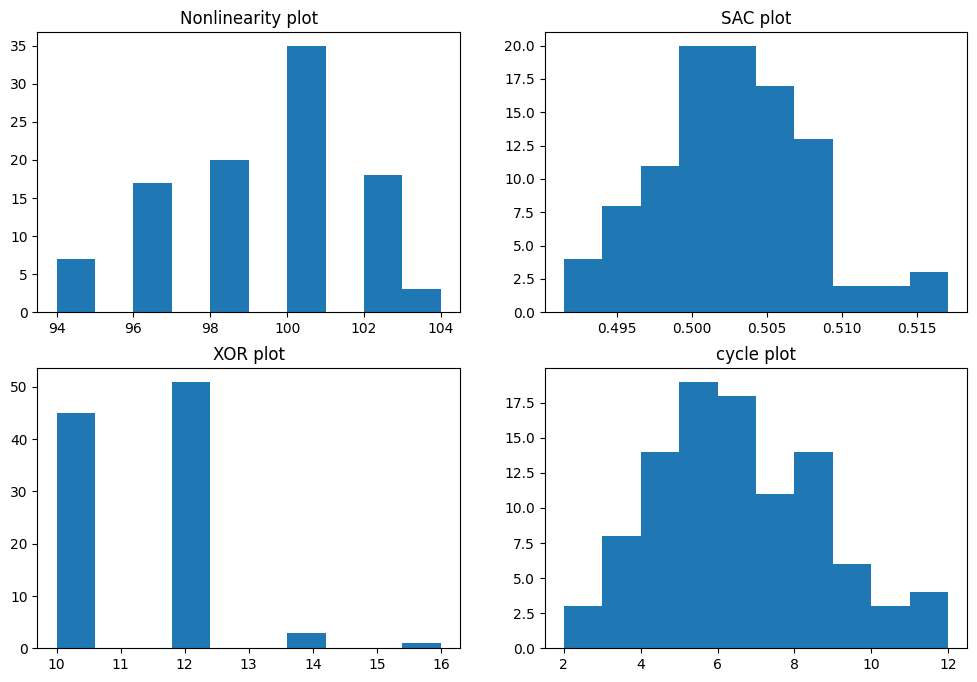

In [224]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

histTitles = ['Nonlinearity plot', 'SAC plot', 'XOR plot', 'cycle plot']
histData = [sboxRandomListInfoNL, sboxRandomListInfoSAC, sboxRandomListInfoXOR, sboxRandomListInfoCycle]
axis = [(0, 0), (0, 1), (1, 0), (1, 1)]


for (testText, value, pos) in zip(histTitles, histData, axis):
    axs[pos[0], pos[1]].hist(value)
    axs[pos[0], pos[1]].set(title=testText)

plt.show()


---
---
---

### Souces
* https://www.geeksforgeeks.org/difference-between-aes-and-des-ciphers/
* https://en.wikipedia.org/wiki/S-box

